# Local parallelization of Hyper Parameter Search


In this notebook, we will tackle the same problem as before but with a focus on parallelization using multiple CPU cores.

Thanks to the joblib library, we will define a new `optimize_study` function and implement the necessary code for parallel execution. This parallelization can significantly speed up the hyperparameter search process.

Additionally, we will provide an example to determine the optimal number of processes to use based on your local computer's capabilities.

### Step 1 : Prepare your data 

The first 3 steps are the same than in the 1st tutorial that explains how to conduct an hyperparameter search with optuna. You can directly jump to the 4th step if you are already familiar with it.

In [4]:
import numpy as np
import reservoirpy as rpy

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import doublescroll
from reservoirpy.observables import nrmse, rsquare

In [3]:
timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")

train_len = 1000

X_train = X[:train_len]
y_train = X[1 : train_len + 1]

X_test = X[train_len : -1]
y_test = X[train_len + 1:]

dataset = ((X_train, y_train), (X_test, y_test))

### Step 2: Define fixed parameters for the hyper parameter search

In [5]:
import os
import time
import joblib
import optuna
import datetime
import matplotlib.pyplot as plt

from optuna.storages import JournalStorage, JournalFileStorage

optuna.logging.set_verbosity(optuna.logging.ERROR)
rpy.verbosity(0)

In [5]:
# Trial Fixed hyper-parameters
nb_seeds = 3
N = 500
iss = 0.9
ridge = 1e-7

### Step 3: Define an Objective Function

In [6]:
def objective(trial):
    # Record objective values for each trial
    losses = []

    # Trial generated parameters (with log scale)
    sr = trial.suggest_float("sr_1", 1e-2, 10, log=True)
    lr = trial.suggest_float("lr_1", 1e-3, 1, log=True)

    for seed in range(nb_seeds):
        reservoir = Reservoir(N,
                              sr=sr,
                              lr=lr,
                              input_scaling=iss,
                              seed=seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout

        # Train and test your model
        predictions = model.fit(X_train, y_train).run(X_test)

        # Compute the desired metrics
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))

        losses.append(loss)

    return np.mean(losses)

### Step 4: Create a Study Optimization function

We will use the `optimize_study` function with joblib to run multiple trials in parallel.

By using joblib's Parallel and delayed functionalities, we can distribute the hyperparameter optimization process across several CPU cores, simultaneously evaluating different trials. This parallelization will accelerate the search for optimal hyperparameters and improve the efficiency of the optimization process.

For the storage, a SQlite one (like in the first tutorial) is not recommended to run parallel experiments as mentionned [here](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/004_distributed.html). Instead, you can use [other storages](https://optuna.readthedocs.io/en/stable/reference/storages.html) proposed by the library. Here we use a `JournalStorage` (If you use Windows and have problems with this storage, you can try to use a SQL one instead). 

In [ ]:
# Define study parameters
nb_trials = 32

sampler = optuna.samplers.RandomSampler() 

study_name = 'optuna_tutorial'
log_name = f"optuna-journal_{study_name}.log"

storage = JournalStorage(JournalFileStorage(log_name))

The argument `load_if_exists=True`enables several processes running in parallel to connect to the same storage.

In [10]:
def optimize_study(n_trials):
    study = optuna.create_study(
        study_name='paralellization_tutorial',
        direction='minimize',
        storage=storage,
        sampler=optuna.samplers.RandomSampler(),
        load_if_exists=True
    )

    for i in range(n_trials):
        trial = study.ask()
        study.tell(trial, objective(trial))

### Step 5: Evaluate the optimal number of processes

In [ ]:
nb_cpus = os.cpu_count()
print(f"Number of available CPUs : {nb_cpus}")

Number of available CPUs : 8


The following function tests the speed of the optimization process for several values of processes (`n_processes`). This function enables you to determine the most efficient number of processes for your specific task. You can experiment with different values (inferior to `nb_cpus`), even on shorter or smaller tasks, to find the optimal configuration. Once you've identified the best number of processes, you can then apply it to the actual task you intend to perform, ensuring optimal performance.

It measures the time taken to complete the optimization with each number of processes and stores the results in the times list. The code divides the total number of trials (`nb_trials`) by the number of processes to determine `n_trials_per_process`. It then uses joblib's Parallel and delayed to run optimize_study function with the specified number of trials (`n_trials_per_process`) in parallel. 

In [11]:
n_processes = [1, 2, 4, 8]
times = []

for n_process in n_processes:
    print("")
    print(f"Optization with n_process = {n_process}")
    start = time.time()

    n_trials_per_process = nb_trials // n_process
    args_list = [n_trials_per_process for i in range(n_process)]

    joblib.Parallel(n_jobs=n_process)(joblib.delayed(optimize_study)(args) for args in args_list)

    end = time.time()
    times.append(end - start)
    print(f"Done in {str(datetime.timedelta(seconds=end-start))}")


Optization with n_process = 1
Optimization with 1 process(es) done in 0:01:04.034894

Optization with n_process = 2


[I 2023-07-28 14:00:03,312] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:03,324] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 2 process(es) done in 0:00:33.124385

Optization with n_process = 4


[I 2023-07-28 14:00:36,677] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,699] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,736] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:36,803] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 4 process(es) done in 0:00:18.272678

Optization with n_process = 8


[I 2023-07-28 14:00:55,097] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,099] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,122] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,138] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,139] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,201] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,210] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.
[I 2023-07-28 14:00:55,278] Using an existing study with name 'paralellization_tutorial' instead of creating a new one.


Optimization with 8 process(es) done in 0:00:10.980919


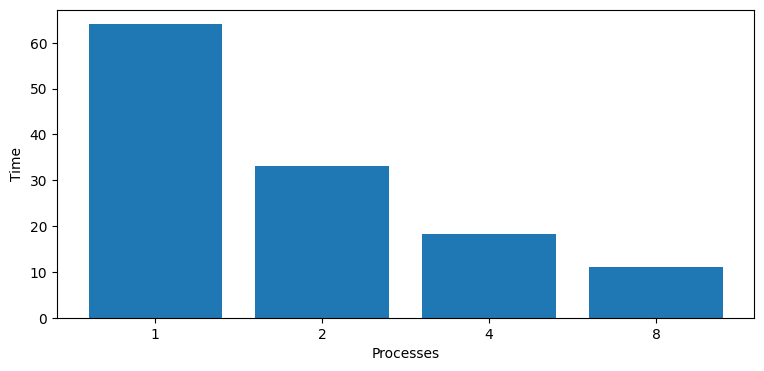

In [13]:
plt.figure(figsize=(9,4))
plt.bar(range(len(n_processes)), times)
plt.xticks(range(len(n_processes)), n_processes)
plt.xlabel("Processes")
plt.ylabel("Time")
plt.show()

In this specific case, it seems useful to run our hyper parameter search with a large number of processes
